In [ ]:
import os
import cv2

input_root = "Train/Drone2"
output_root = "./"
frame_quality = [cv2.IMWRITE_JPEG_QUALITY, 95]

os.makedirs(output_root, exist_ok=True)


for time_of_day in ['morning','noon']:
    input_time_path = os.path.join(input_root, time_of_day)
    output_time_path = os.path.join(output_root, time_of_day)
    os.makedirs(output_time_path, exist_ok=True)

    for video_name in os.listdir(input_time_path):
        video_path = os.path.join(input_time_path, video_name)
        video_base = os.path.splitext(video_name)[0]


        output_video_folder = os.path.join(output_time_path, video_base)
        os.makedirs(output_video_folder, exist_ok=True)


        cap = cv2.VideoCapture(video_path)
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_filename = f"frame_{frame_idx:04d}.jpg"
            output_path = os.path.join(output_video_folder, frame_filename)
            cv2.imwrite(output_path, frame, frame_quality)
            frame_idx += 1

        cap.release()
        print(f"Extracted {frame_idx} frames from: {video_name}")


Extracted 1217 frames from: 2.1.1.mp4
Extracted 2713 frames from: 2.1.10.mp4
Extracted 1398 frames from: 2.1.2.mp4
Extracted 2878 frames from: 2.1.3.mp4
Extracted 2108 frames from: 2.1.4.mp4
Extracted 1799 frames from: 2.1.5.mp4
Extracted 2518 frames from: 2.1.6.mp4
Extracted 2510 frames from: 2.1.7.mp4
Extracted 1262 frames from: 2.2.11.mp4
Extracted 1466 frames from: 2.2.2.mp4
Extracted 2006 frames from: 2.2.4.mp4
Extracted 1021 frames from: 2.2.5.mp4
Extracted 2246 frames from: 2.2.6.mp4
Extracted 1504 frames from: 2.2.7.mp4
Extracted 1768 frames from: 2.2.8.mp4
Extracted 1501 frames from: 2.2.9.mp4


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from collections import defaultdict


def simple_enhance(image):
    img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    img_pil = ImageEnhance.Brightness(img_pil).enhance(1.05)
    img_pil = ImageEnhance.Contrast(img_pil).enhance(1.1)
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

def process_okutama_dataset(images_dir, labels_dir, output_dir, padding=0.15):
    os.makedirs(output_dir, exist_ok=True)
    generated_counter = defaultdict(int)
    for video_folder in sorted(os.listdir(images_dir)):

        if video_folder in retained_dirs:
            video_path = os.path.join(images_dir, video_folder)
            if not os.path.isdir(video_path): continue

            label_path = os.path.join(labels_dir, f"{video_folder}.txt")
            if not os.path.exists(label_path):
                print(f"Label missing for {video_folder}")
                continue

            print(f" Processing: {video_folder}")

            with open(label_path, 'r') as file:
                lines = file.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) < 11: continue

                try:
                    track_id = int(parts[0])
                    x1, y1, x2, y2 = map(int, parts[1:5])
                    frame_id = int(parts[5])
                    lost = int(parts[6])
                    generated = int(parts[8])
                    if lost == 1: continue
                    if generated == 1:
                      generated_counter[track_id] += 1
                      if generated_counter[track_id] % 5 != 0:
                          continue
                    actions = [a.strip('"').lower() for a in parts[10:]]
                    if not actions: continue
                except ValueError:
                    continue

                w = x2 - x1
                h = y2 - y1
                x1_pad = max(0, x1 - int(w * padding))
                y1_pad = max(0, y1 - int(h * padding))
                x2_pad = min(3839, x2 + int(w * padding))
                y2_pad = min(2159, y2 + int(h * padding))

                frame_file = os.path.join(video_path, f"frame_{frame_id:04d}.jpg")
                if not os.path.exists(frame_file): continue

                image = cv2.imread(frame_file)
                if image is None: continue

                crop = image[y1_pad:y2_pad, x1_pad:x2_pad]
                if crop.size == 0: continue

                crop = cv2.resize(crop, (224, 224), interpolation=cv2.INTER_AREA)
                crop = simple_enhance(crop)

                action_folder = "_".join(actions)
                folder_name = f"{video_folder}person{track_id}_{action_folder}"
                save_path = os.path.join(output_dir, folder_name)
                os.makedirs(save_path, exist_ok=True)

                save_name = f"{frame_id:05d}.jpg"
                cv2.imwrite(os.path.join(save_path, save_name), crop)

In [ ]:
images_dir = r"./Okutama_Frames"
labels_dir = r"./Train/Labels/MultiActionLabels/3840x2160"
output_dir = r"./crops_1"

process_okutama_dataset(images_dir, labels_dir, output_dir)

In [ ]:
import os


main_folder = "/content/drive/MyDrive/traindataset/crop_dataset/balanced_crops_1"

=
image_extensions = {'.jpg'}

max_folder = None
min_folder = None
max_count = 0
min_count = float('inf')


def count_images_recursively(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                count += 1
    return count


for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        count = count_images_recursively(subfolder_path)
        print(f"{subfolder}: {count} images")

        if count > max_count:
            max_count = count
            max_folder = subfolder

        if count < min_count:
            min_count = count
            min_folder = subfolder


print("\nFolder with maximum images:")
print(f"{max_folder} --> {max_count} images")

print("Folder with minimum images:")
print(f"{min_folder} --> {min_count} images")


2.1.2person41_standing: 50 images
2.1.2person42_walking: 27 images
2.1.2person43_walking: 19 images
2.1.2person45_walking_pushing: 50 images
2.1.2person44_standing: 50 images
2.1.2person46_sitting_hand_shaking: 7 images
2.1.2person47_sitting_hand_shaking: 7 images
2.1.2person46_sitting: 47 images
2.1.2person47_sitting_reading: 10 images
2.1.2person47_sitting: 38 images
2.1.2person48_lying: 50 images
2.1.2person49_lying: 40 images
2.1.2person50_standing: 40 images
2.1.2person51_walking: 10 images
2.1.2person52_sitting: 41 images
2.1.3person0_walking_pushing: 50 images
2.1.2person53_sitting_reading: 40 images
2.1.3person1_standing: 50 images
2.1.3person2_standing: 50 images
2.1.3person3_walking_carrying: 50 images
2.1.3person4_sitting: 50 images
2.1.3person5_sitting: 50 images
2.1.3person6_walking: 32 images
2.1.3person8_walking_pushing: 50 images
2.1.3person7_standing: 24 images
2.1.3person9_standing: 50 images
2.1.3person10_standing: 50 images
2.1.3person11_walking_carrying: 21 images


<ipython-input-7-3338825600>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[item[0] for item in top_items], y=[item[1] for item in top_items], palette="mako")


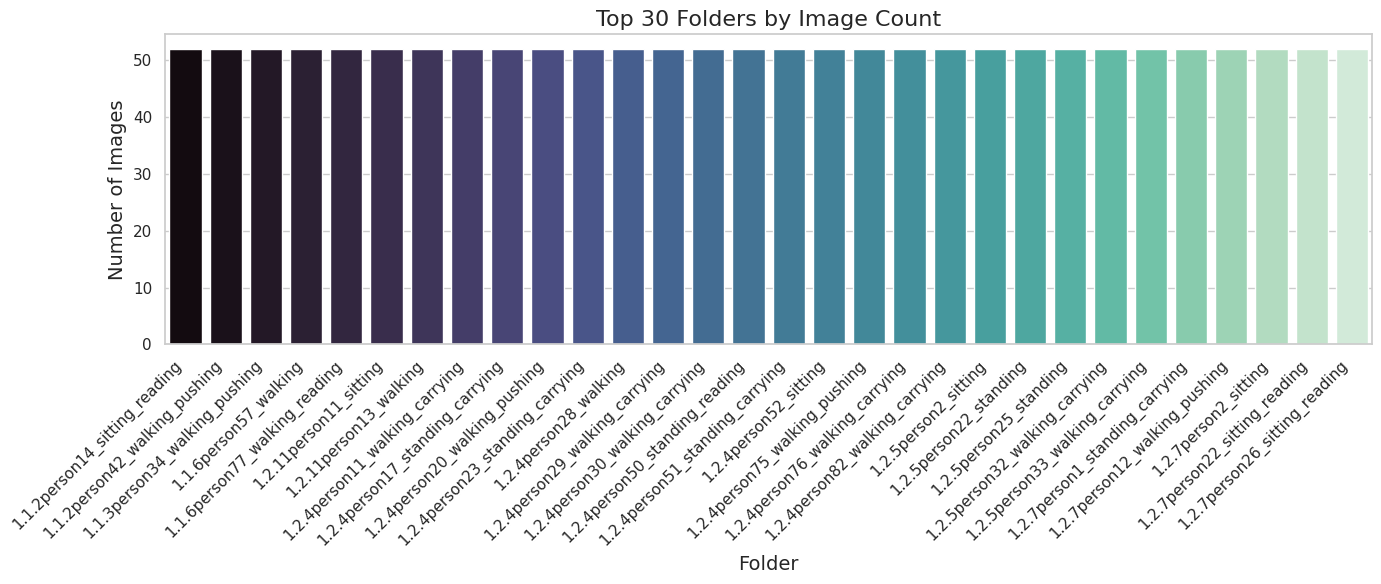

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

main_folder = "/content/drive/MyDrive/traindataset/crop_dataset/crops_1"
image_extensions = {'.jpg'}

def count_images_recursively(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                count += 1
    return count

folder_counts = {}

for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        folder_counts[subfolder] = count_images_recursively(subfolder_path)


sorted_counts = dict(sorted(folder_counts.items(), key=lambda item: item[1], reverse=True))

top_n = 30
top_items = list(sorted_counts.items())[:top_n]

sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
sns.barplot(x=[item[0] for item in top_items], y=[item[1] for item in top_items], palette="mako")

plt.title(f"Top {top_n} Folders by Image Count", fontsize=16)
plt.xlabel("Folder", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


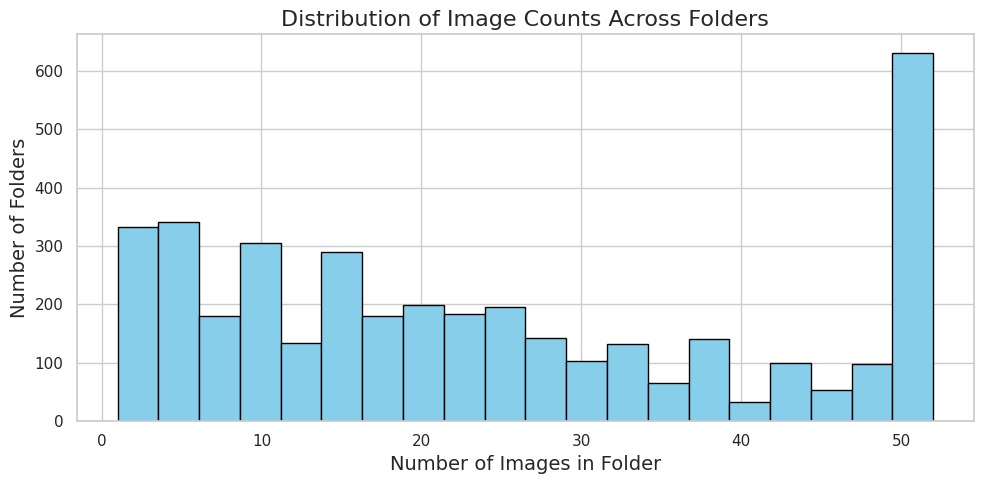

In [ ]:
import os
import matplotlib.pyplot as plt

main_folder = "/content/drive/MyDrive/traindataset/crop_dataset/crops_1"


image_extensions = {'.jpg'}

# Function to count images recursively
def count_images_recursively(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                count += 1
    return count

folder_counts = []
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        folder_counts.append(count_images_recursively(subfolder_path))


plt.figure(figsize=(10, 5))
plt.hist(folder_counts, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Image Counts Across Folders", fontsize=16)
plt.xlabel("Number of Images in Folder", fontsize=14)
plt.ylabel("Number of Folders", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import os
import numpy as np
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Layer



In [ ]:
data_root = "/content/drive/MyDrive/Drone2"
img_size = (224, 224)
sequence_length = 50
min_frames =20
num_threads =20


In [ ]:
class self_attention(Layer):
  def __init__(self,reduction_ratio=16):
      super().__init__()
      self.reduction_ratio=reduction_ratio

  def build(self,input_shape):
    last_dim = input_shape[-1]
    self.dense1 = Dense(last_dim//self.reduction_ratio,activation='relu')
    self.dense2= Dense(last_dim,activation='sigmoid')


  def call(self,inputs):
    avg_pooling= tf.reduce_mean(inputs,axis=[1,2])
    x=self.dense1(avg_pooling)
    x=self.dense2(x)
    x=tf.expand_dims(tf.expand_dims(x,1),1)
    return inputs*x



In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x =self_attention()(x)
x = GlobalAveragePooling2D()(x)
resnet_model = Model(inputs=base_model.input, outputs=x)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
actions = [
    'handshaking', 'hugging', 'reading', 'drinking',
    'pushing', 'carrying', 'calling',
    'running', 'walking', 'lying', 'sitting', 'standing'
]
action_to_index = {a: i for i, a in enumerate(actions)}
phrase_map = {
    'hand_shaking': 'handshaking',
}

def get_multihot_label(folder_name):
    parts = folder_name.split("person")[-1]
    words = parts.split("_")[1:]
    joined = "_".join(words)
    for phrase, replacement in phrase_map.items():
        joined = joined.replace(phrase, replacement)
    action_list = joined.split("_")
    label = np.zeros(len(action_to_index), dtype=np.float32)
    for a in action_list:
        if a in action_to_index:
            label[action_to_index[a]] = 1
    return label


In [ ]:
def extract_sequence_features(sequence_path, frame_files, model):
    seq_feats = []
    for frame_file in frame_files:
        frame_path = os.path.join(sequence_path, frame_file)
        img = load_img(frame_path, target_size=img_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feat = model.predict(x, verbose=0)
        seq_feats.append(feat.squeeze())
    while len(seq_feats) < sequence_length:
        seq_feats.append(seq_feats[-1])
    return np.array(seq_feats[:sequence_length])


In [ ]:

def process_folder(folder):
    if "person" not in folder:
        return None
    sequence_path = os.path.join(data_root, folder)
    if not os.path.isdir(sequence_path):
        return None
    frame_files = sorted([
        f for f in os.listdir(sequence_path)
        if f.endswith('.jpg')
    ])
    if len(frame_files) < min_frames:
        return None
    frame_files = frame_files[:sequence_length]
    seq_feats = extract_sequence_features(sequence_path, frame_files, resnet_model)
    label = get_multihot_label(folder)
    return seq_feats, label


In [ ]:
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

def load_features_parallel():
    folders = sorted(os.listdir(data_root))
    folders = folders[:401]
    total = len(folders)
    print(f"🔍 Processing {total} folders...")

    os.makedirs("/content/drive/MyDrive/features1", exist_ok=True)
    os.makedirs("/content/drive/MyDrive/labels1", exist_ok=True)

    count = 0
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = {}
        for folder in folders:
            safe_name = folder.replace("/", "_")
            feature_path = f"/content/drive/MyDrive/features1/{safe_name}_feat.npy"
            label_path = f"/content/drive/MyDrive/labels1/{safe_name}_label.npy"


            if os.path.exists(feature_path) and os.path.exists(label_path):
                print(f"⏭️ Skipped (already processed): {folder}")
                continue

            # Schedule for processing
            futures[executor.submit(process_folder, folder)] = (folder, feature_path, label_path)

        for future in as_completed(futures):
            folder, feature_path, label_path = futures[future]
            result = future.result()

            if result:
                feat, label = result
                np.save(feature_path, feat)
                np.save(label_path, label)
                count += 1
                print(f"✅ [{count}/{total}] Saved: {folder}")
            else:
                print(f"⚠️ Skipped (invalid or not enough frames): {folder}")

    print("\n✅ All possible folders processed and saved.")


In [ ]:
load_features_parallel()

🔍 Processing 701 folders...
⏭️ Skipped (already processed): 2.1.10person101_standing_calling
⏭️ Skipped (already processed): 2.1.10person101_walking_calling
⏭️ Skipped (already processed): 2.1.10person102_walking_pushing
⏭️ Skipped (already processed): 2.1.10person103_walking_pushing
⏭️ Skipped (already processed): 2.1.10person104_running
⏭️ Skipped (already processed): 2.1.10person105_walking
⏭️ Skipped (already processed): 2.1.10person105_walking_carrying
⏭️ Skipped (already processed): 2.1.10person107_walking_carrying
⏭️ Skipped (already processed): 2.1.10person10_standing_reading
⏭️ Skipped (already processed): 2.1.10person110_standing_carrying
⏭️ Skipped (already processed): 2.1.10person112_standing_carrying
⏭️ Skipped (already processed): 2.1.10person112_standing_reading
⏭️ Skipped (already processed): 2.1.10person114_walking
⏭️ Skipped (already processed): 2.1.10person115_walking_calling
⏭️ Skipped (already processed): 2.1.10person117_standing
⏭️ Skipped (already processed): 2.1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/tmp/ipython-input-8-2562942849.py", line 30, in load_features_parallel
    for future in as_completed(futures):
  File "/usr/lib/python3.11/concurrent/futures/_base.py", line 243, in as_completed
    waiter.event.wait(wait_timeout)
  File "/usr/lib/python3.11/threading.py", line 629, in wait
    signaled = self._cond.wait(timeout)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/threading.py", line 327, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-9-3681683132.py", line 1, in <cell line: 0>
    load_features_parallel()
  File "/tmp/ipython-input-8-2562942849.py", line 15, in load_features_parallel
    with ThreadPoolExecutor(max_worker

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

